# Dataset Bespoke Subsampling Demo

This notebook demonstrates how to subsample a dataset to have a specific episode return histogram.

In [1]:
from og_marl.vault_utils.download_vault import *
from flashbax.vault import Vault
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from og_marl.vault_utils.analyse_vault import *
from og_marl.vault_utils.subsample_bespoke import bin_processed_data,episode_idxes_sampled_from_pdf
from og_marl.vault_utils.subsample_similar import sort_concat, stitch_vault_from_sampled_episodes_, get_episode_returns_and_term_idxes

See dataset_analysis_demo for more information on downloading and accessing OG-MARL vaults.

In [2]:
# download / make sure dataset exists
source = 'og_marl'
env = 'smac_v1'
task = '2s3z'

rel_vault_location = download_and_unzip_vault(source,env,task)
vault_uids = get_available_uids(rel_vault_location)

vault_rel_dir = f"vaults/{source}/{env}" # combine base vault directory with the dataset source and environment folders
vault_name = f"{task}.vlt" # a vault name contains only the file name which has the .vlt extension
vault_uid = vault_uids[0] # we select the first dataset in the vault

vlt = Vault(rel_dir=vault_rel_dir, vault_name=vault_name, vault_uid=vault_uid)

Vault './vaults/og_marl/smac_v1/2s3z' already exists.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor


For further information about a Vault's api, please see the dataset api demo.

## Subsample a vault "by hand"

Given a histogram of episode returns, we allow subsampling a vault according to the histogram in a flexible way. That is, we allow individul specification of the size of each bucket.

### Dataset description to guide subsampling

In [3]:
# it can be useful to have experience handy at this level
all_data = vlt.read()
offline_data = all_data.experience
del all_data

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
returns, episode_end_idxes = get_episode_returns_and_term_idxes(offline_data)
sorted_return_start_end = sort_concat(returns,episode_end_idxes)
bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers = bin_processed_data(sorted_return_start_end, n_bins=300)

9942
9942


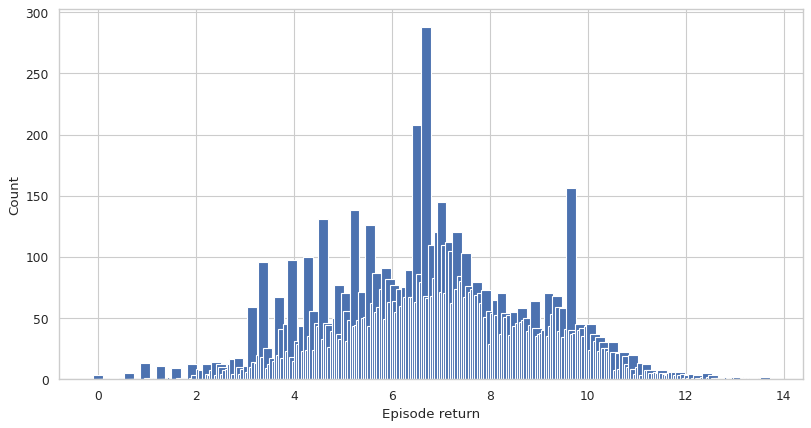

[  3   1   5  13   1   1  11   2   1   9   1   1  12   1   3   8   7  12
   4   3   7  14   3  12  10   4   7   8  12  16   4  17  10   4   8  11
   6  59  10  14  13  20  96  18  25   9  12  17  15  67  20  41  17  45
  23  97  18  15  31  29  43  23 100  24  35  56  24  46  43 131  33  46
  44  26  39  50  77  37  33  70  56  31  48 138  43  44  48  71  50  51
 126  43  62  87  55  59  74  91  49  82  63  77  64  55  74  60  75  67
  89  67  67 208  63  86  79 288  68  66 110  68  83 120 145  71 110  70
 112 105  62 120  74  84  80 103  67  76  71  74  79  69  70  62  73  51
  56  29  54  65  52  70  37  54  51  52  36  55  43  46  58  47  48  50
  39  44  64  42  35  37  38  40  70  35  43  53  68  59  39  58  34  41
 156  40  37  38  45  40  42  35  43  45  24  37  31  34  23  30  25  25
  23  30  22   7  21   8  22  19  12  10  20   8   4  10  13   3  12   7
   7   5   5   6   5   7   5   4   3   5   6   6   3   6   3   4   1   3
   1   4   1   3   1   2   5   2   3   1   1   1   

In [5]:
# print the histogram to show the distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(bin_edges,padded_heights,width=0.2)
plt.ylabel("Count")
plt.xlabel("Episode return")
plt.show()

print(bar_heights)

### Plot a pdf under the distribution to specify how many episodes to sample

Although we allow manual specification of how many episodes to sample from each bucket, it can be easier to sample according to a distribution defined by a function. We use the Gaussian distribution as an example.

Important to note, we plot the distribution with bin numbers as the unit since it is dataset-agnostic.

In [6]:
def my_pdf(x_vals,x_shift,std_dev,volume):
    """
    x_vals: generally, the bin indices (excluding bins containing zero episodes)
    x_shift: defines the mean of the distribution
    std_dev: defines the slope of the pdf
    volume: volume*std_dev is the approximate number of sampled episodes
    """
    y_vals = norm.pdf((np.array((x_vals))-x_shift)/std_dev)*volume
    
    return y_vals

In [7]:
def tbl_mtn_pdf(x_vals,x_shift,x_stretch,y_stretch):

    # pieces of piecewise "table mountain" function
    pieces = [lambda a:a/3,
                  lambda b:b-2/3,
                  lambda c:1.5*c-1-2/3,
                  lambda d:-0.5*d+2.7+0.1/3,
                  lambda e:2*e-4.7-0.2/3,
                  lambda f:1.7+0.1/3,
                  lambda g:-6*g+43.7+0.1/3,
                  lambda h:-0.45*h+4.7168+0.0001/3,
                  lambda l:l-7.8981-0.0002/3,
                  lambda m:-0.7*m+7.7418+0.0002/3
                  ]
    
    y_vals = []
    for x in x_vals:

        x_temp = x/x_stretch-x_shift
        y_val = 0

        # if x in range of the respective piece, apply piece of function
        if x_temp>=0:
            if x_temp<1:
                y_val = pieces[0](x_temp)
            elif x_temp<2:
                y_val = pieces[1](x_temp)
            elif x_temp<2.2:
                y_val = pieces[2](x_temp)
            elif x_temp<3:
                y_val = pieces[3](x_temp)
            elif x_temp<3.25:
                y_val = pieces[4](x_temp)
            elif x_temp<7:
                y_val = pieces[5](x_temp)
            elif x_temp<7.03:
                y_val = pieces[6](x_temp)
            elif x_temp<8.7:
                y_val = pieces[7](x_temp)
            elif x_temp<9.2:
                y_val = pieces[8](x_temp)
            elif x_temp<11:
                y_val = pieces[9](x_temp)

        # if x not inside the mountain,this is 0
        y_vals.append(y_stretch*y_val)
        
    return y_vals
    

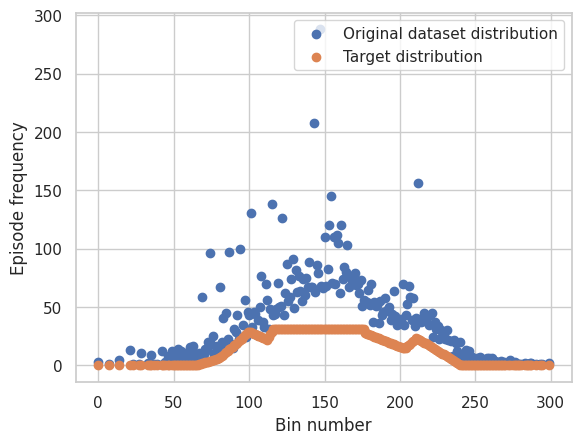

In [8]:
# visualise original distribution
plt.scatter(bar_labels,bar_heights,label='Original dataset distribution')
tbl_mtn_pdf_vals = tbl_mtn_pdf(bar_labels,4,16,18)
plt.scatter(bar_labels,tbl_mtn_pdf_vals,label='Target distribution')
plt.legend()
plt.ylabel("Episode frequency")
plt.xlabel("Bin number")
plt.savefig("pdf_under_dist.pdf",bbox_inches='tight',format='pdf')
plt.show()

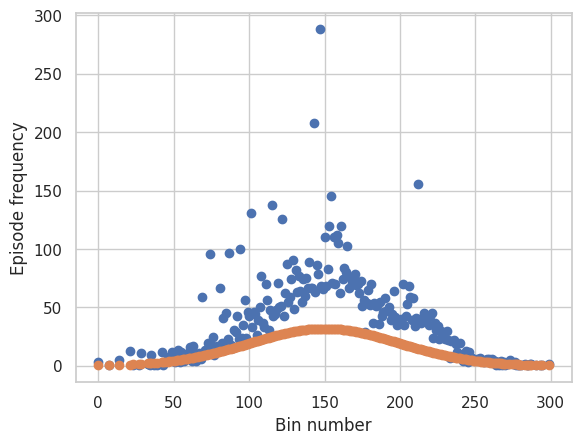

In [9]:
# visualise original distribution
plt.scatter(bar_labels,bar_heights)
norm_pdf_vals = my_pdf(bar_labels,150,50,80)
plt.scatter(bar_labels,norm_pdf_vals)
plt.ylabel("Episode frequency")
plt.xlabel("Bin number")
plt.savefig("pdf_under_dist.pdf",bbox_inches='tight',format='pdf')
plt.show()

Generally, you want the sampling pdf to lie below the actual pdf. We allow for oversampling (then episodes are repeated), but it will in essence just impact the bias towards the resampled episodes.

3941
3941


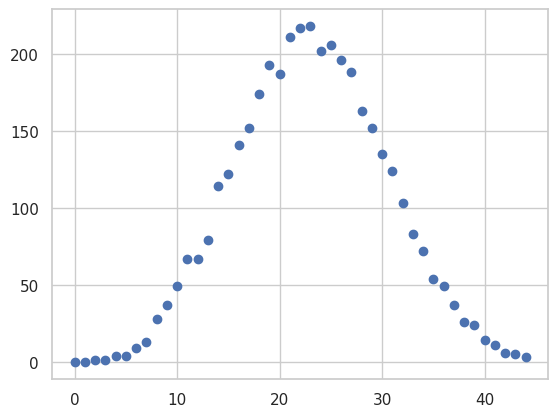

6.8534856
2.1651475
3941
3754
3754


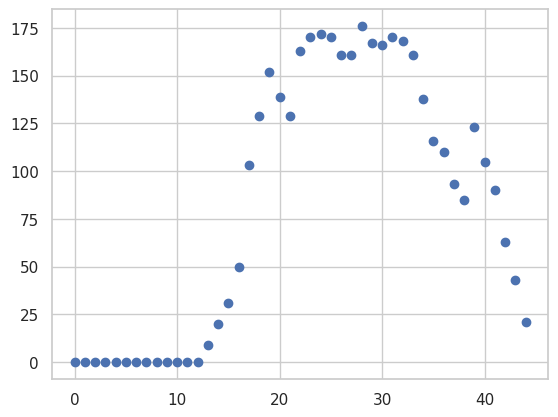

6.893283
1.8081112
3754


In [10]:
target_pdfs = [norm_pdf_vals,tbl_mtn_pdf_vals]

target_infoblocks = []
for pdf in target_pdfs:
    # from each bin, select indexes to slice the return_start_end info block
    target_sample_idxes = episode_idxes_sampled_from_pdf(pdf,bar_heights)

    # do the selection according to the indices you just sampled
    target_return_start_end = sorted_return_start_end[np.array(target_sample_idxes).astype(int),:]

    # visualise the subsampled distribution
    bar_labels_t, bar_heights_t, padded_heights_t, bin_edges_t, bin_numbers_t = bin_processed_data(target_return_start_end, n_bins=45)
    bins_t = range(len(padded_heights_t))
    plt.scatter(bins_t,padded_heights_t)
    plt.show()

    # further print the mean and stddev of episode returns of the subsampled distribution
    print(np.mean(target_return_start_end[:,0]))
    print(np.std(target_return_start_end[:,0]))
    print(len(target_return_start_end))

    target_infoblocks.append(target_return_start_end)

## Now restitch the vault using the experience from before. 
A sanity check afterwards is recommended.

Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/temp_bespoke_subsampling/Poor_Normal
393521
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/temp_bespoke_subsampling/Poor_Table_Mountain
370774
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/temp_bespoke_subsampling/Poor_Table_Mountain
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/temp_bespoke_subsampling/Poor_Normal
Uid                     Mean    Stddev    Min return    Max return    Transitions    Trajectories    Joint SACo
-------------------  -------  --------  ------------  ------------  -------------  --------------  ------------
Poor_Table_Mountain  6.89328   1.80811      2.98039        10.8627         741548            7508      0.482876
Poor_Normal          6.85349   2.16515      0.313726       13.3652         787042            7882      0.480448


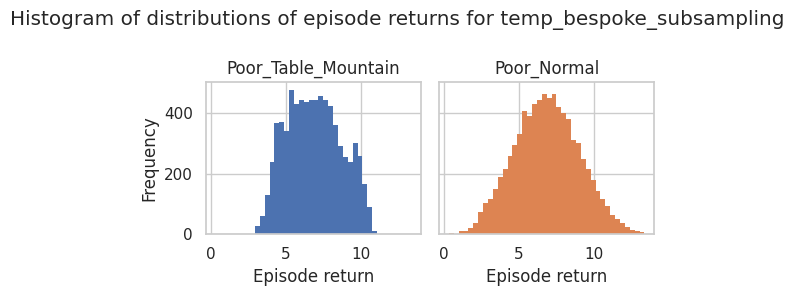

In [12]:
dest_vault_name = 'temp_bespoke_subsampling'

new_uids = ['Normal','Table_Mountain']

for new_uid,infoblock in zip(new_uids,target_infoblocks):
    stitch_vault_from_sampled_episodes_(offline_data,infoblock,dest_vault_name,rel_dir=vault_rel_dir,vault_uid=f'{vault_uid}_{new_uid}',n=1000000)

returns = descriptive_summary(dest_vault_name,rel_dir=vault_rel_dir,save_hist=True)